In [1]:
import pandas as pd
import numpy as np

In [2]:
# 读入数据
data_src = pd.read_csv("./data/train.csv", index_col=0)
# 取一部分数据
#data_src = data_src[:10000]
data_src

,heartbeat_signals,label
id,,
0,"0.9912297987616655,0.9435330436439665,0.764677...",0.0
1,"0.9714822034884503,0.9289687459588268,0.572932...",0.0
2,"1.0,0.9591487564065292,0.7013782792997189,0.23...",2.0
3,"0.9757952826275774,0.9340884687738161,0.659636...",0.0
4,"0.0,0.055816398940721094,0.26129357194994196,0...",2.0
...,...,...
99995,"1.0,0.677705342021188,0.22239242747868546,0.25...",0.0
99996,"0.9268571578157265,0.9063471198026871,0.636993...",2.0
99997,"0.9258351628306013,0.5873839035878395,0.633226...",3.0


In [3]:
# 分割训练集和测试集
from sklearn.model_selection import train_test_split

trainData = []
trainLabel = []
for i in range(data_src.shape[0]):
    trainData.append(data_src['heartbeat_signals'][i].split(','))
    trainLabel.append(data_src['label'][i])

trainData = np.array(trainData).astype(np.float64)
trainLabel = np.array(trainLabel).astype(np.float64)

trainData,testData,trainLabel,testLabel=train_test_split(trainData,trainLabel,test_size=0.2)

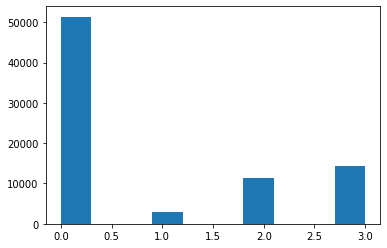

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# 各类别数量
plt.hist(trainLabel, orientation = 'vertical', histtype = 'bar')
plt.show()

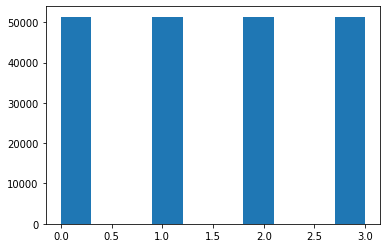

In [16]:
from imblearn.over_sampling import SMOTE

# 使用 SMOTE 对数据进行上采样以解决类别不平衡问题
smote = SMOTE(random_state=0, n_jobs=-1)
trainData, trainLabel = smote.fit_resample(trainData, trainLabel)

# SMOTE处理后的类别数量
plt.hist(trainLabel, orientation = 'vertical', histtype = 'bar')
plt.show()

In [4]:
# 计算分类准确率，和预测差值
def calcDiff(predLabel,testLabel):
    diff = 0
    score = 0
    samples = predLabel.shape[0]
    for i in range(samples):
        pvec = predLabel[i]
        if np.isscalar(predLabel[i]):
            pvec = [0,0,0,0]
            pvec[int(predLabel[i])] = 1
        tvec = testLabel[i]
        if np.isscalar(testLabel[i]):
            tvec = [0,0,0,0]
            tvec[int(testLabel[i])] = 1
        diff = diff + sum(abs(np.array(pvec)-np.array(tvec)))
        if np.argmax(pvec) == np.argmax(tvec):
            score = score + 1
    return [score/samples, diff]

In [5]:
# 多层感知机
from sklearn.neural_network import MLPClassifier

# 训练
model_mlp = MLPClassifier(hidden_layer_sizes=(100,100),max_iter=400)
model_mlp.fit(trainData,trainLabel)

# 测试
predTrain_mlp = model_mlp.predict(trainData)
predTest_mlp = model_mlp.predict(testData)
print("训练集得分：",calcDiff(predTrain_mlp,trainLabel))
print("测试集得分：",calcDiff(predTest_mlp,testLabel))

训练集得分： [0.9955375, 714]
测试集得分： [0.98495, 602]


In [6]:
# LightGBM
import lightgbm as lgb

params={
    "learning rate":0.2,
    "boosting":"gbdt",
    "lambda_12":0.1,
    "max_depth":-1,
    "num_leaves":128,
    "bagging_fraction":0.8,
    "feature_fraction":0.8,
    "metric":None,
    "objective":"multiclass",
    "num_class":4,
    "nthread":10,
    "verbose":-1,
}

# 训练
model_lgb=lgb.train(params,
               train_set=lgb.Dataset(trainData,label=trainLabel),
               valid_sets=lgb.Dataset(testData,label=testLabel),
               num_boost_round=50)

# 测试
predTrain_lgb = model_lgb.predict(trainData,num_iteration=model_lgb.best_iteration)
predTest_lgb = model_lgb.predict(testData,num_iteration=model_lgb.best_iteration)
print("训练集得分：",calcDiff(predTrain_lgb, trainLabel))
print("测试集得分：",calcDiff(predTest_lgb, testLabel))

[LightGBM] [Warning] Unknown parameter: learning
[LightGBM] [Warning] Unknown parameter: rate
[LightGBM] [Warning] Unknown parameter: lambda_12
[1]	valid_0's multi_logloss: 0.757781
[2]	valid_0's multi_logloss: 0.632232
[3]	valid_0's multi_logloss: 0.5386
[4]	valid_0's multi_logloss: 0.465743
[5]	valid_0's multi_logloss: 0.406394
[6]	valid_0's multi_logloss: 0.358356
[7]	valid_0's multi_logloss: 0.317963
[8]	valid_0's multi_logloss: 0.28423
[9]	valid_0's multi_logloss: 0.255605
[10]	valid_0's multi_logloss: 0.230665
[11]	valid_0's multi_logloss: 0.209419
[12]	valid_0's multi_logloss: 0.19072
[13]	valid_0's multi_logloss: 0.174941
[14]	valid_0's multi_logloss: 0.160971
[15]	valid_0's multi_logloss: 0.148925
[16]	valid_0's multi_logloss: 0.138543
[17]	valid_0's multi_logloss: 0.129365
[18]	valid_0's multi_logloss: 0.121255
[19]	valid_0's multi_logloss: 0.114165
[20]	valid_0's multi_logloss: 0.107868
[21]	valid_0's multi_logloss: 0.102243
[22]	valid_0's multi_logloss: 0.0972659
[23]	valid

In [7]:
# 随机森林
from sklearn.ensemble import RandomForestRegressor

# 训练
model_rfr = RandomForestRegressor(random_state=0, n_estimators=200, n_jobs=-1)
model_rfr.fit(trainData,trainLabel)

# 测试
predTrain_rfr = model_rfr.predict(trainData)
predTest_rfr = model_rfr.predict(testData)
print("训练集得分：",calcDiff(predTrain_rfr,trainLabel))
print("测试集得分：",calcDiff(predTest_rfr,testLabel))

训练集得分： [0.9001625, 15974]
测试集得分： [0.87945, 4822]


In [8]:
# 支持向量机
from sklearn import svm

# 训练
model_svm = svm.SVC(gamma='scale')
model_svm.fit(trainData,trainLabel)

# 测试
predTrain_svm = model_svm.predict(trainData)
predTest_svm = model_svm.predict(testData)
print("训练集得分：",calcDiff(predTrain_svm,trainLabel))
print("测试集得分：",calcDiff(predTest_svm,testLabel))

训练集得分： [0.9714875, 4562]
测试集得分： [0.96975, 1210]


In [9]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

# 训练
model_knn = KNeighborsClassifier(n_neighbors=1,  n_jobs=-1)
model_knn.fit(trainData,trainLabel)

# 测试
predTrain_knn = model_knn.predict(trainData)
predTest_knn = model_knn.predict(testData)
print("训练集得分：",calcDiff(predTrain_knn,trainLabel))
print("测试集得分：",calcDiff(predTest_knn,testLabel))

训练集得分： [1.0, 0]
测试集得分： [0.9857, 572]


In [10]:
# CNN
from keras import Sequential
from keras.optimizers import adam_v2
from keras.initializers import glorot_normal
from keras.layers import Conv1D, LeakyReLU, Flatten, Dense

# 构建模型
model_cnn = Sequential()
model_cnn.add(Conv1D(8, 11, kernel_initializer=glorot_normal(seed=1), input_shape=(205, 1)))
model_cnn.add(LeakyReLU(alpha=0.05))
model_cnn.add(Conv1D(16, 9, kernel_initializer=glorot_normal(seed=1)))
model_cnn.add(LeakyReLU(alpha=0.05))
model_cnn.add(Conv1D(32, 5, kernel_initializer=glorot_normal(seed=1)))
model_cnn.add(LeakyReLU(alpha=0.05))
model_cnn.add(Conv1D(64, 3, kernel_initializer=glorot_normal(seed=1)))
model_cnn.add(LeakyReLU(alpha=0.05))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, kernel_initializer=glorot_normal(seed=1)))
model_cnn.add(LeakyReLU(alpha=0.05))
model_cnn.add(Dense(4, activation='softmax', kernel_initializer=glorot_normal(seed=1)))
adam = adam_v2.Adam()
model_cnn.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['acc'])

# 数据格式转化为keras的输入格式
trainLabelVec = (np.arange(4) == trainLabel[:, None]).astype(int) 

# 训练
model_cnn.fit(trainData,trainLabelVec,
              batch_size=128, epochs=60,
              shuffle=False,
              verbose=1)
              #class_weight={0:1, 1:8, 2:3, 3:3}) # 为防止类别不平衡指定的类别权重

# 测试
predTrain_cnn = model_cnn.predict(trainData)
predTest_cnn = model_cnn.predict(testData)
print("训练集得分：",calcDiff(predTrain_cnn,trainLabel))
print("测试集得分：",calcDiff(predTest_cnn,testLabel))

Epoch 1/60
625/625 [==============================] - 21s 33ms/step - loss: 0.3772 - acc: 0.9129
Epoch 2/60
625/625 [==============================] - 20s 33ms/step - loss: 0.1865 - acc: 0.9600
Epoch 3/60
625/625 [==============================] - 20s 32ms/step - loss: 0.1342 - acc: 0.9708
Epoch 4/60
625/625 [==============================] - 20s 32ms/step - loss: 0.1007 - acc: 0.9774
Epoch 5/60
625/625 [==============================] - 20s 32ms/step - loss: 0.0821 - acc: 0.9810
Epoch 6/60
625/625 [==============================] - 20s 32ms/step - loss: 0.0658 - acc: 0.9839
Epoch 7/60
625/625 [==============================] - 20s 32ms/step - loss: 0.0537 - acc: 0.9871
Epoch 8/60
625/625 [==============================] - 20s 32ms/step - loss: 0.0463 - acc: 0.9886
Epoch 9/60
625/625 [==============================] - 20s 32ms/step - loss: 0.0396 - acc: 0.9899
Epoch 10/60
625/625 [==============================] - 20s 32ms/step - loss: 0.0342 - acc: 0.9915
Epoch 11/60
625/625 [========

In [18]:
# 融合各模型的预测值，采用简单的投票法
def fuseModelPredict(predLabels):
    models = len(predLabels)
    samples = predLabels[0].shape[0]
    
    predLabelFuse = []
    
    for i in range(samples):
        pvecFuse = np.array([0,0,0,0])
        for m in range(models):
            pvec = predLabels[m][i]
            if np.isscalar(pvec):
                pvec = [0,0,0,0]
                pvec[int(predLabels[m][i])] = 1
            pvecFuse = pvecFuse + np.array(pvec)
            
        predC = np.argmax(pvecFuse)
        pvecFuse = [0,0,0,0]
        pvecFuse[predC] = 1
        predLabelFuse.append(pvecFuse)
    
    return np.array(predLabelFuse)

# 模型融合 LGB+KNN+CNN
print("融合模型 训练集得分：",calcDiff(fuseModelPredict([predTrain_lgb,predTrain_knn,predTrain_cnn]),trainLabel))
print("融合模型 测试集得分：",calcDiff(fuseModelPredict([predTest_lgb,predTest_knn,predTest_cnn]),testLabel))

融合模型 训练集得分： [1.0, 0]
融合模型 测试集得分： [0.9911, 356]
